# Project: Bank Fraud Detection

**We will use logistic regression and neural network to solve a bank fraud detection case.**

In [230]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import datasets, model_selection, linear_model, metrics, tree, svm
from sklearn.metrics import classification_report
import os

**Data:**
There are 23 features for each user, which are discribed below

**id**: A unique Id field which represents a customer

**X1**: Credit line

**X2**: Gender (1 = male; 2 = female).

**X3**: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others). 

**X4**: Marital status (1 = married; 2 = single; 3 = others).

**X5**: Age (year).

**X6 - X11**: History of past payment. 

**X6** = September, 2015;

**X7** = August, 2015;

**...**

**X11** =April, 2015; where -1 = pay one month ahead; -2 = pay two month ahead; 0 = pay on time; Positive means the payment delayed months, 1 = delay 1 month, 2 = delay 2 months, etc.

**X12- X17**: Amount in bill statement.

**X12** = amount of bill statement September, 2015

**X13** = amount of bill statement August, 2015

**...**

**X17** = amount of bill statement April, 2015. 

**X18-X23**: Amount of previous payment

**X18** = amount paid in September, 2015; 

**X19** = amount paid in August, 2015; 

**...**

**X23** = amount paid in April, 2015.

**Y**: Whether the customer is creditable (1) or not (0).

### 1. Load data

In [12]:
train = pd.read_csv('/Users/Rockwell/Desktop/Bank-Fraud-Detection/train.csv')
train.head()

,id,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,1,200000,2,3,1,53,0,0,0,0,...,133207,136159,138741,6500,5000,5000,5100,5000,5400,0
1,2,130000,2,3,2,39,0,0,0,2,...,130814,130758,123468,7500,10000,0,4500,4500,4179,0
2,3,350000,2,1,2,41,0,0,0,0,...,119947,117328,118400,6000,5900,5800,4100,4500,5000,0
3,4,240000,2,2,1,43,1,-2,-2,-1,...,12700,12500,26225,0,0,12700,0,13725,0,0
4,5,180000,1,2,2,28,-1,-1,-1,-1,...,332,416,416,0,416,332,500,3500,832,0


In [10]:
train.shape

(25000, 25)

In [23]:
# check missing values
train.isna().sum().sum() 

0

**Hence, no missing value.**

In [20]:
# Check the value types
train.dtypes

id     int64
X1     int64
X2     int64
X3     int64
X4     int64
X5     int64
X6     int64
X7     int64
X8     int64
X9     int64
X10    int64
X11    int64
X12    int64
X13    int64
X14    int64
X15    int64
X16    int64
X17    int64
X18    int64
X19    int64
X20    int64
X21    int64
X22    int64
X23    int64
Y      int64
dtype: object

**All in integers.**

In [28]:
# find the categorical features
train.nunique()

id     25000
X1        79
X2         2
X3         7
X4         4
X5        56
X6        11
X7        11
X8        11
X9        11
X10       10
X11       10
X12    19387
X13    19025
X14    18745
X15    18423
X16    17923
X17    17577
X18     7150
X19     7062
X20     6697
X21     6217
X22     6143
X23     6169
Y          2
dtype: int64

### 2. Feature engineering

**It can be seen that X2, X3, X4 are categorical features, i.e.,**

**X2**: Gender (1 = male; 2 = female).

**X3**: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others). 

**X4**: Marital status (1 = married; 2 = single; 3 = others).

**Also X1, X5, X6 - X11 are discrete features**

**X1**: Credit line

**X5**: Age (year).

**X6 - X11**: History of past payment, where -1 = pay one month ahead; -2 = pay two month ahead; 0 = pay on time; Positive means the payment delayed months, 1 = delay 1 month, 2 = delay 2 months, etc.

**Last other features are continuous features**

**X12- X17**: Amount in bill statement.

**X18-X23**: Amount of previous payment

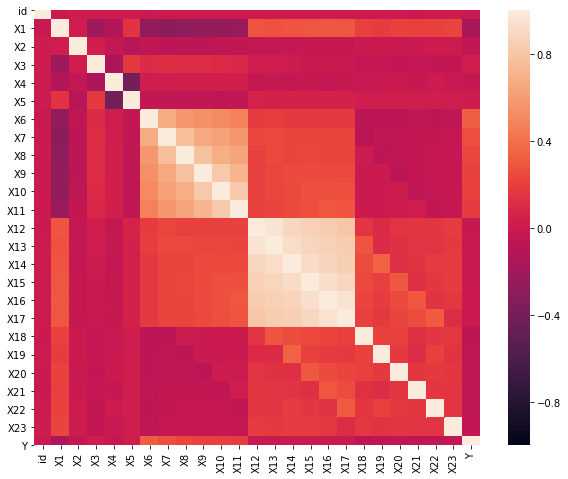

In [57]:
# Check the correlations (it doesn't hurt to include all, since they are all ingeters)
plt.figure(figsize=(10,8))
sns.heatmap(train.corr(), vmin=-1, vmax=1)
plt.show()

**From the above figure, we can find X4 and X5 has negative correlation, pairs in X12-X17 have positive correlation. For accuracy we use values to decide. Let %97.5 be a threshold.**

In [58]:
# select the upper triangle matrix of the correlation matrix
df_corr = train.corr()
df_corr_upper = pd.DataFrame(np.triu(df_corr, k=1)).abs()

In [67]:
# column indices with abs correlation larger than the threshold.
dropcols_index = [j for j in range(len(df_corr_upper.columns)) if any(df_corr_upper.iloc[:,j] > 0.975)]
dropcols_index

[]

**Hence, no strong correlation over the threshold, 97.5%**

**Categorical feature encoding: one-hot encoding will be used in this analysis**

In [85]:
# one-hot encoding for X2 (gender), X3(education), X4(martial status)
train_onehot = train.copy()
train_onehot = pd.get_dummies(train_onehot, columns=['X2', 'X3', 'X4'], prefix=['X2', 'X3', 'X4'])
train_onehot

,id,X1,X5,X6,X7,X8,X9,X10,X11,X12,...,X3_1,X3_2,X3_3,X3_4,X3_5,X3_6,X4_0,X4_1,X4_2,X4_3
0,1,200000,53,0,0,0,0,0,0,126027,...,0,0,1,0,0,0,0,1,0,0
1,2,130000,39,0,0,0,2,0,0,133825,...,0,0,1,0,0,0,0,0,1,0
2,3,350000,41,0,0,0,0,0,0,122017,...,1,0,0,0,0,0,0,0,1,0
3,4,240000,43,1,-2,-2,-1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
4,5,180000,28,-1,-1,-1,-1,-1,-1,1832,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,24996,300000,56,1,-2,-2,-2,-2,-2,0,...,1,0,0,0,0,0,0,1,0,0
24996,24997,230000,36,0,0,0,2,0,0,3745,...,0,1,0,0,0,0,0,1,0,0
24997,24998,30000,23,2,2,2,2,2,2,34048,...,0,1,0,0,0,0,0,0,1,0
24998,24999,360000,36,0,0,0,0,0,0,28291,...,1,0,0,0,0,0,0,1,0,0


In [86]:
# remove the id column
train_onehot.drop(labels='id', axis=1, inplace=True)
# move label column to the last
feature_cols = [col for col in train_onehot.columns if col != 'Y']
train_onehot = train_onehot[feature_cols + ['Y']]
# split data to train and validation
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(train_onehot.iloc[:,:-1], train_onehot['Y'], test_size=0.2)

In [94]:
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(20000, 33) (5000, 33) (20000,) (5000,)


### 3. Logistic regression

In [132]:
# build logistic regression model
lm_lr = linear_model.LogisticRegression(max_iter=1000, solver='lbfgs', tol=0.05, penalty='l2')

In [133]:
lm_lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.05, verbose=0,
                   warm_start=False)

In [134]:
# Confusion matrix for training set (col1-actual incredible, col2-actual credible)
metrics.confusion_matrix(lm_lr.predict(X_train), y_train)

array([[15562,  4435],
       [    3,     0]])

In [135]:
# Confusion matrix for validation set (col1-actual incredible, col2-actual credible)
metrics.confusion_matrix(lm_lr.predict(X_valid), y_valid)

array([[3887, 1113],
       [   0,    0]])

In [148]:
# Check the performance in the training data
print(classification_report(y_train, lm_lr.predict(X_train), target_names=['Incredible', 'Credible']))

              precision    recall  f1-score   support

  Incredible       0.78      1.00      0.88     15565
    Credible       0.00      0.00      0.00      4435

    accuracy                           0.78     20000
   macro avg       0.39      0.50      0.44     20000
weighted avg       0.61      0.78      0.68     20000



In [149]:
# Check the performance in the validation data
print(classification_report(y_valid, lm_lr.predict(X_valid), target_names=['Incredible', 'Credible']))

              precision    recall  f1-score   support

  Incredible       0.78      1.00      0.87      3887
    Credible       0.00      0.00      0.00      1113

    accuracy                           0.78      5000
   macro avg       0.39      0.50      0.44      5000
weighted avg       0.60      0.78      0.68      5000



/Users/Rockwell/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


**From the confusion matrices and performance reports for both training and validation sets, we can see the logistic regression model has a high recall on incredible users, which is actually a good aspects for fraud detection.**

**However, the precision on incredible users are just 78% and there are only a few customers are recogonized as credible in the training data and 0 user recogonized as credible in the validation data. This could lead to a problem of mistakenly regarding too many valuable and credible users as bad users. Thus the credit card company might lose a lot of business opportunities and revenue from it. Hence the logistic regression model is not ideal enough and could be improved.**

**If we use the original values without one-hot encoding**

In [151]:
# split data to train and validation
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(train.iloc[:,:-1], train['Y'], test_size=0.2)

In [152]:
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(20000, 24) (5000, 24) (20000,) (5000,)


In [153]:
# build logistic regression model
lm_lr = linear_model.LogisticRegression(max_iter=1000, solver='lbfgs', tol=0.05, penalty='l2')
lm_lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.05, verbose=0,
                   warm_start=False)

In [154]:
# Confusion matrix for training set (col1-actual incredible, col2-actual credible)
metrics.confusion_matrix(lm_lr.predict(X_train), y_train)

array([[15515,  4482],
       [    2,     1]])

In [155]:
# Confusion matrix for validation set (col1-actual incredible, col2-actual credible)
metrics.confusion_matrix(lm_lr.predict(X_valid), y_valid)

array([[3935, 1065],
       [   0,    0]])

In [156]:
# Check the performance in the training data
print(classification_report(y_train, lm_lr.predict(X_train), target_names=['Incredible', 'Credible']))

              precision    recall  f1-score   support

  Incredible       0.78      1.00      0.87     15517
    Credible       0.33      0.00      0.00      4483

    accuracy                           0.78     20000
   macro avg       0.55      0.50      0.44     20000
weighted avg       0.68      0.78      0.68     20000



In [157]:
# Check the performance in the validation data
print(classification_report(y_valid, lm_lr.predict(X_valid), target_names=['Incredible', 'Credible']))

              precision    recall  f1-score   support

  Incredible       0.79      1.00      0.88      3935
    Credible       0.00      0.00      0.00      1065

    accuracy                           0.79      5000
   macro avg       0.39      0.50      0.44      5000
weighted avg       0.62      0.79      0.69      5000



/Users/Rockwell/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


**It can be seen that without one-hot encoding, the performance is almost the same.**

**If we use decision tree, instead**

In [159]:
# build decision tree model
d_dtc = tree.DecisionTreeClassifier()
d_dtc.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [160]:
metrics.confusion_matrix(d_dtc.predict(X_train), y_train)

array([[15517,     0],
       [    0,  4483]])

In [161]:
metrics.confusion_matrix(d_dtc.predict(X_valid), y_valid)

array([[3160,  608],
       [ 775,  457]])

In [162]:
# Check the performance in the training data
print(classification_report(y_train, d_dtc.predict(X_train), target_names=['Incredible', 'Credible']))

              precision    recall  f1-score   support

  Incredible       1.00      1.00      1.00     15517
    Credible       1.00      1.00      1.00      4483

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



In [164]:
# Check the performance in the validation data
print(classification_report(y_valid, d_dtc.predict(X_valid), target_names=['Incredible', 'Credible']))

              precision    recall  f1-score   support

  Incredible       0.84      0.80      0.82      3935
    Credible       0.37      0.43      0.40      1065

    accuracy                           0.72      5000
   macro avg       0.60      0.62      0.61      5000
weighted avg       0.74      0.72      0.73      5000



**It can be seen from the above results, decision tree model generate a better performance than logistic regression, F1-score for weighted avg is 0.73 > 0.69**

**Even though the recall for credible users increase a lot, the recall for the incredible users descrease from 1 to 0.82. Also the trained model performs perfect on training set but not very good on validation set, which means we overfit the model, so some parameters should be tuned**

**First to simplify the tree structure, limit the maximum layers to a lower number**

In [227]:
# build decision tree model
d_dtc = tree.DecisionTreeClassifier(max_depth=5)
d_dtc.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [228]:
# Check the performance in the training data
print(classification_report(y_train, d_dtc.predict(X_train), target_names=['Incredible', 'Credible']))

              precision    recall  f1-score   support

  Incredible       0.84      0.95      0.89     15517
    Credible       0.69      0.37      0.48      4483

    accuracy                           0.82     20000
   macro avg       0.77      0.66      0.69     20000
weighted avg       0.81      0.82      0.80     20000



In [229]:
# Check the performance in the validation data
print(classification_report(y_valid, d_dtc.predict(X_valid), target_names=['Incredible', 'Credible']))

              precision    recall  f1-score   support

  Incredible       0.85      0.95      0.89      3935
    Credible       0.65      0.37      0.47      1065

    accuracy                           0.82      5000
   macro avg       0.75      0.66      0.68      5000
weighted avg       0.81      0.82      0.80      5000



**After tests, 5 seems to be the best max_depth of the decision tree here**

**If we use SVM instead**

In [231]:
# build SVM model
lm_svm = svm.SVC()
# one-hot encoding for X2 (gender), X3(education), X4(martial status)
train_onehot = train.copy()
train_onehot = pd.get_dummies(train_onehot, columns=['X2', 'X3', 'X4'], prefix=['X2', 'X3', 'X4'])
# remove the id column
train_onehot.drop(labels='id', axis=1, inplace=True)
# move label column to the last
feature_cols = [col for col in train_onehot.columns if col != 'Y']
train_onehot = train_onehot[feature_cols + ['Y']]
# split data to train and validation
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(train_onehot.iloc[:,:-1], train_onehot['Y'], test_size=0.2)
lm_svm.fit(X_train, y_train)

/Users/Rockwell/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [232]:
# Check the performance in the training data
print(classification_report(y_train, lm_svm.predict(X_train), target_names=['Incredible', 'Credible']))

              precision    recall  f1-score   support

  Incredible       0.99      1.00      1.00     15574
    Credible       1.00      0.98      0.99      4426

    accuracy                           0.99     20000
   macro avg       0.99      0.99      0.99     20000
weighted avg       0.99      0.99      0.99     20000



In [233]:
# Check the performance in the validation data
print(classification_report(y_valid, lm_svm.predict(X_valid), target_names=['Incredible', 'Credible']))

              precision    recall  f1-score   support

  Incredible       0.78      1.00      0.87      3878
    Credible       0.28      0.00      0.01      1122

    accuracy                           0.77      5000
   macro avg       0.53      0.50      0.44      5000
weighted avg       0.66      0.77      0.68      5000



In [234]:
metrics.confusion_matrix(lm_svm.predict(X_valid), y_valid)

array([[3865, 1117],
       [  13,    5]])

Y: Whether the customer is creditable (1) or not (0).

In [ ]:
train_onehot.iloc[:,]

In [69]:
pd.get_dummies?

In [66]:
df_corr_upper[13]

0     0.001130
1     0.280592
2     0.031349
3     0.020601
4     0.021781
5     0.054481
6     0.189426
7     0.235497
8     0.237268
9     0.228966
10    0.227513
11    0.226232
12    0.953280
13    0.000000
14    0.000000
15    0.000000
16    0.000000
17    0.000000
18    0.000000
19    0.000000
20    0.000000
21    0.000000
22    0.000000
23    0.000000
24    0.000000
Name: 13, dtype: float64

In [62]:
pd.DataFrame(np.triu(df_corr, k=1))

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.0,-0.010927,0.009357,0.011085,0.006236,0.002785,-0.013010,-0.003427,-0.003398,-0.006683,...,0.003564,0.000946,0.002937,-0.004026,0.001017,-0.000824,-0.007956,0.001265,0.011715,-0.011036
1,0.0,0.000000,0.020158,-0.218146,-0.108082,0.146040,-0.269031,-0.294042,-0.284668,-0.265610,...,0.296105,0.297241,0.290695,0.206108,0.183218,0.216725,0.207212,0.217500,0.221568,-0.151796
2,0.0,0.000000,0.000000,0.017601,-0.033518,-0.093670,-0.055302,-0.070673,-0.069609,-0.062832,...,-0.021682,-0.017099,-0.015890,-0.003745,-0.003297,-0.013489,-0.003352,0.001262,0.000361,-0.039079
3,0.0,0.000000,0.000000,0.000000,-0.143747,0.175792,0.106437,0.122677,0.115285,0.109460,...,-0.000155,-0.007273,-0.008891,-0.036637,-0.025835,-0.039079,-0.034714,-0.039863,-0.040715,0.028698
4,0.0,0.000000,0.000000,0.000000,0.000000,-0.409655,0.019301,0.023908,0.033900,0.032555,...,-0.023045,-0.025737,-0.021259,-0.009763,-0.013899,-0.007025,-0.019684,0.000256,-0.008729,-0.026604
5,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-0.041626,-0.051128,-0.052158,-0.047212,...,0.050483,0.049132,0.048283,0.022077,0.020411,0.027147,0.022989,0.026681,0.019138,0.013517
6,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.668198,0.571157,0.536765,...,0.177300,0.179473,0.175145,-0.077022,-0.069982,-0.075602,-0.059953,-0.063772,-0.057523,0.324682
7,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.763583,0.660798,...,0.221580,0.221521,0.219480,-0.081517,-0.060890,-0.061362,-0.044351,-0.040995,-0.036924,0.260485
8,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.777303,...,0.227214,0.225591,0.223093,0.004562,-0.067174,-0.056452,-0.043607,-0.037254,-0.036090,0.232668
9,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.248268,0.245534,0.241713,-0.007669,-0.001222,-0.072779,-0.041293,-0.034664,-0.027573,0.213566


In [ ]:
# split the data to train and validation set
X_train, X_test, y_train, y_test = model_selection.train_test_split(train[:,:-2], Y, test_size=0.2)

**2. check the data quality**

In [6]:
test3 = pd.read_csv('/Users/Rockwell/Desktop/Bank-Fraud-Detection/train.csv')
test3

,id,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,1,200000,2,3,1,53,0,0,0,0,...,133207,136159,138741,6500,5000,5000,5100,5000,5400,0
1,2,130000,2,3,2,39,0,0,0,2,...,130814,130758,123468,7500,10000,0,4500,4500,4179,0
2,3,350000,2,1,2,41,0,0,0,0,...,119947,117328,118400,6000,5900,5800,4100,4500,5000,0
3,4,240000,2,2,1,43,1,-2,-2,-1,...,12700,12500,26225,0,0,12700,0,13725,0,0
4,5,180000,1,2,2,28,-1,-1,-1,-1,...,332,416,416,0,416,332,500,3500,832,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,24996,300000,2,1,1,56,1,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,1
24996,24997,230000,2,2,1,36,0,0,0,2,...,631,1635,10244,3000,2023,0,1004,10019,1141,0
24997,24998,30000,2,2,2,23,2,2,2,2,...,41931,38638,35343,0,1800,9851,0,1183,5132,0
24998,24999,360000,1,1,1,36,0,0,0,0,...,36491,41179,45823,3000,3000,3000,5000,5000,5000,0


In [5]:
test2 = pd.read_csv('/Users/Rockwell/Desktop/Bank-Fraud-Detection/test.csv')
test2

,id,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23
0,25001,180000,1,1,2,27,-1,0,0,0,...,6482,3246,2016,2334,12000,5004,1000,1000,2300,3000
1,25002,230000,2,3,1,52,-2,-2,-2,-2,...,2233,1410,0,0,3939,2244,1421,0,0,236
2,25003,150000,2,1,2,28,-1,-1,2,-1,...,1159,1159,11476,10249,2468,0,1159,11476,0,2034
3,25004,160000,1,1,1,40,0,0,2,2,...,3503,-473,3757,3286,3000,0,0,4700,0,3000
4,25005,20000,2,2,2,26,0,0,0,0,...,8515,6584,3403,3748,2600,1500,1500,1000,402,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,29996,120000,2,1,2,25,-1,-1,-1,-1,...,3938,1110,9848,3301,12557,3938,1110,9848,3301,0
4996,29997,200000,2,2,1,39,0,0,2,0,...,149765,131741,134488,137240,9201,5000,4500,4600,4700,5319
4997,29998,370000,1,1,2,30,0,0,0,0,...,285705,295747,250158,255956,13000,11000,15000,10000,10000,12000
4998,29999,20000,1,2,1,35,1,2,2,0,...,20018,20427,19377,19386,1000,1000,1000,1500,900,1000
